<h1>Predicting Rush Or Pass LightGBM Model</h1>

<h2>Setup Environment</h2>

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import nfl_data_py as nfl

<h2>Load Data</h2>

In [8]:
years = [2024]
play_by_play = nfl.import_pbp_data(years, downcast=True, cache=False)

2024 done.
Downcasting floats.


<h2>Preview Data</h2>

In [9]:
play_by_play.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49492 entries, 0 to 49491
Columns: 372 entries, play_id to pass_oe
dtypes: float32(199), int32(7), int64(1), object(165)
memory usage: 101.6+ MB


In [10]:
cols = ["home_team", "away_team", "week", "game_seconds_remaining", "down", "yards_gained", "passer_player_name", "rusher_player_name", "receiver_player_name", "home_coach", "away_coach", "temp", "wind"]
play_by_play[cols].head()

,home_team,away_team,week,game_seconds_remaining,down,yards_gained,passer_player_name,rusher_player_name,receiver_player_name,home_coach,away_coach,temp,wind
0,BUF,ARI,1,3600.0,NaN,NaN,None,None,None,Sean McDermott,Jonathan Gannon,61.0,20.0
1,BUF,ARI,1,3600.0,NaN,0.0,None,None,None,Sean McDermott,Jonathan Gannon,61.0,20.0
2,BUF,ARI,1,3600.0,1.0,3.0,None,J.Conner,None,Sean McDermott,Jonathan Gannon,61.0,20.0
3,BUF,ARI,1,3567.0,2.0,22.0,K.Murray,None,J.Conner,Sean McDermott,Jonathan Gannon,61.0,20.0
4,BUF,ARI,1,3523.0,1.0,9.0,K.Murray,None,J.Conner,Sean McDermott,Jonathan Gannon,61.0,20.0


<h2>Label Creation</h2>
<p>Let's see how well the model does with no feature engineering or data filtering. Here, we simply create a label that identifies the current row's next play, for prediction purposes.</p>

In [12]:
play_by_play["play_type"].value_counts(dropna=False)

# Normalize the play_type string
play_by_play['play_type_norm'] = play_by_play['play_type'].astype(str).str.strip().str.lower()

In [13]:
# We only care about pass and run, move all other play types into other
def simple_map(x):
    if x == 'pass':
        return 'pass'
    if x == 'run':
        return 'run'
    return 'other'

play_by_play['play_type_simple'] = play_by_play['play_type_norm'].apply(simple_map).astype('category')

print("Counts:")
print(play_by_play['play_type_simple'].value_counts(dropna=False))
play_by_play.drop(['play_type_norm'],axis=1,inplace=True)

Counts:
pass     20006
run      15044
other    14442
Name: play_type_simple, dtype: int64


In [15]:
# Add next play type but first ensure the data is sorted so each play is in order
play_by_play["down_sort"] = play_by_play["down"].fillna(0)
play_by_play_sorted = play_by_play.sort_values(
    by=["game_id", "game_seconds_remaining", "down_sort", "play_id"],
    ascending=[True, False, True, True]
).drop(columns="down_sort")

# then group by each game
play_by_play_sorted["next_play_type"] = (
    play_by_play_sorted.groupby("game_id")["play_type_simple"]
      .shift(-1)   # shift backwards, so next row’s play_type
)

play_by_play_sorted["next_play_type"].head()

0    other
1      run
2     pass
3     pass
4      run
Name: next_play_type, dtype: category
Categories (3, object): ['other', 'pass', 'run']

In [17]:
# Keep only rows where next play is run or pass; build binary label (pass=1, rush=0)
play_by_play_sorted = play_by_play_sorted[play_by_play_sorted["next_play_type"].isin(["pass", "run"])].copy()
y = (play_by_play_sorted["next_play_type"] == "pass").astype(int)

# Drop target column
drop_cols = ["next_play_type"]
X = play_by_play_sorted.drop(columns=[c for c in drop_cols if c in play_by_play_sorted.columns])

<h2>Model Building</h2>

In [18]:
# Split by game
groups = play_by_play_sorted["game_id"] if "game_id" in play_by_play_sorted.columns else pd.Series(np.arange(len(play_by_play_sorted)))
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# We’ll encode after splitting to avoid leakage from encoders (fit on train only)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

In [19]:
# Splitting the dataset into the training set and test set
X_train_raw, X_test_raw = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [20]:
# Categorical handling for LightGBM
obj_cols = X_train_raw.select_dtypes(include=["object"]).columns
for c in obj_cols:
    X_train_raw[c] = X_train_raw[c].astype("category")
    X_test_raw[c]  = X_test_raw[c].astype("category")

# Keep track of categorical column names
categorical_cols = list(X_train_raw.select_dtypes(include=["category"]).columns)

In [21]:
# Train LightGBM with early stopping
clf = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

clf.fit(
    X_train_raw, y_train,
    eval_set=[(X_test_raw, y_test)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(100), log_evaluation(50)]   # replaces early_stopping_rounds & verbose
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 15945, number of negative: 12084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45505
[LightGBM] [Info] Number of data points in the train set: 28029, number of used features: 338
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568875 -> initscore=0.277263
[LightGBM] [Info] Start training from score 0.277263
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.613558
[100]	valid_0's binary_logloss: 0.63149
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.610887


LGBMClassifier(learning_rate=0.05, n_estimators=2000, n_jobs=-1,
               random_state=42)

<h2>Predictions and Performance Metric</h2>

In [25]:
y_pred = clf.predict(X_test_raw)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["rush","pass"]))

Accuracy: 0.6590229312063809
F1: 0.7093954843408595
Confusion matrix:
 [[1705 1255]
 [1139 2922]]
              precision    recall  f1-score   support

        rush       0.60      0.58      0.59      2960
        pass       0.70      0.72      0.71      4061

    accuracy                           0.66      7021
   macro avg       0.65      0.65      0.65      7021
weighted avg       0.66      0.66      0.66      7021



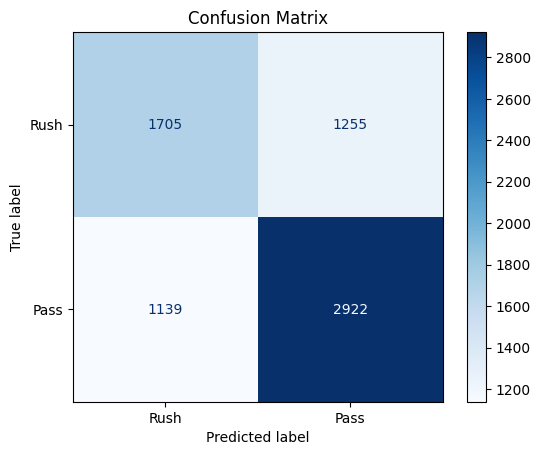

In [26]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Rush","Pass"], cmap="Blues"
)
plt.title("Confusion Matrix")
plt.show()

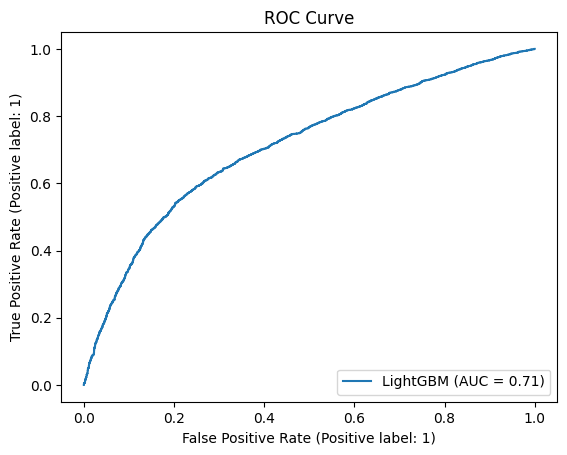

In [27]:
RocCurveDisplay.from_estimator(clf, X_test_raw, y_test, name="LightGBM")
plt.title("ROC Curve")
plt.show()

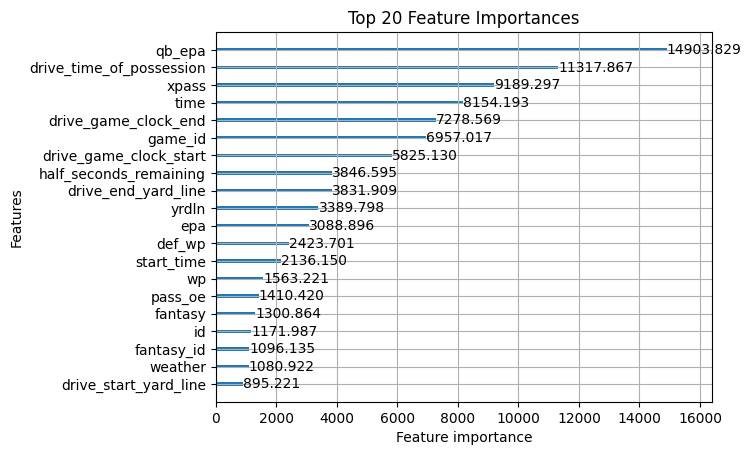

In [28]:
lgb.plot_importance(clf, max_num_features=20, importance_type="gain")
plt.title("Top 20 Feature Importances")
plt.show()

In [ ]:
PrecisionRecallDisplay.from_estimator(clf, X_test_raw, y_test, name="LightGBM")
plt.title("Precision-Recall Curve")
plt.show()

<h2>Summary</h2>
<p>
Overall Accuracy: ~66%
This means the model correctly predicted whether the next play was a pass or a rush 2 out of 3 times. Not bad for a first attempt with no engineered features.

Class-by-Class Performance

Rush Plays (label = 0):
Precision: 0.60 (6 of 10 predicted rushes were correct)
Recall: 0.58 (it only caught ~58% of actual rush plays)
F1-score: 0.59

Pass Plays (label = 1):
Precision: 0.70 (7 of 10 predicted passes were correct)
Recall: 0.72 (it caught ~72% of actual pass plays)
F1-score: 0.71

The model is currently better at predicting passes than rushes. It tends to miss rushes and predicts pass instead.</p>